# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

## CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="https://github.com/yandexdataschool/Practical_DL/blob/spring23/week03_convnets/cifar10.jpg?raw=1" style="width:80%">

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

device_str = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_str)
device

device(type='cuda')

In [ ]:
def submission(accuracy):
    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(accuracy * 100))

    if accuracy * 100 > 95:
        print("Double-check, than consider applying for NIPS'17. SRSly.")
    elif accuracy * 100 > 90:
        print("U'r freakin' amazin'!")
    elif accuracy * 100 > 80:
        print("Achievement unlocked: 110lvl Warlock!")
    elif accuracy * 100 > 70:
        print("Achievement unlocked: 80lvl Warlock!")
    elif accuracy * 100 > 60:
        print("Achievement unlocked: 70lvl Warlock!")
    elif accuracy * 100 > 50:
        print("Achievement unlocked: 60lvl Warlock!")
    else:
        print("We need more magic! Follow instructons below")

In [ ]:
# when running in colab, un-comment this
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py
!pip install lightning

ipd.clear_output()

In [ ]:
from cifar import load_cifar10

X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape, y_train.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


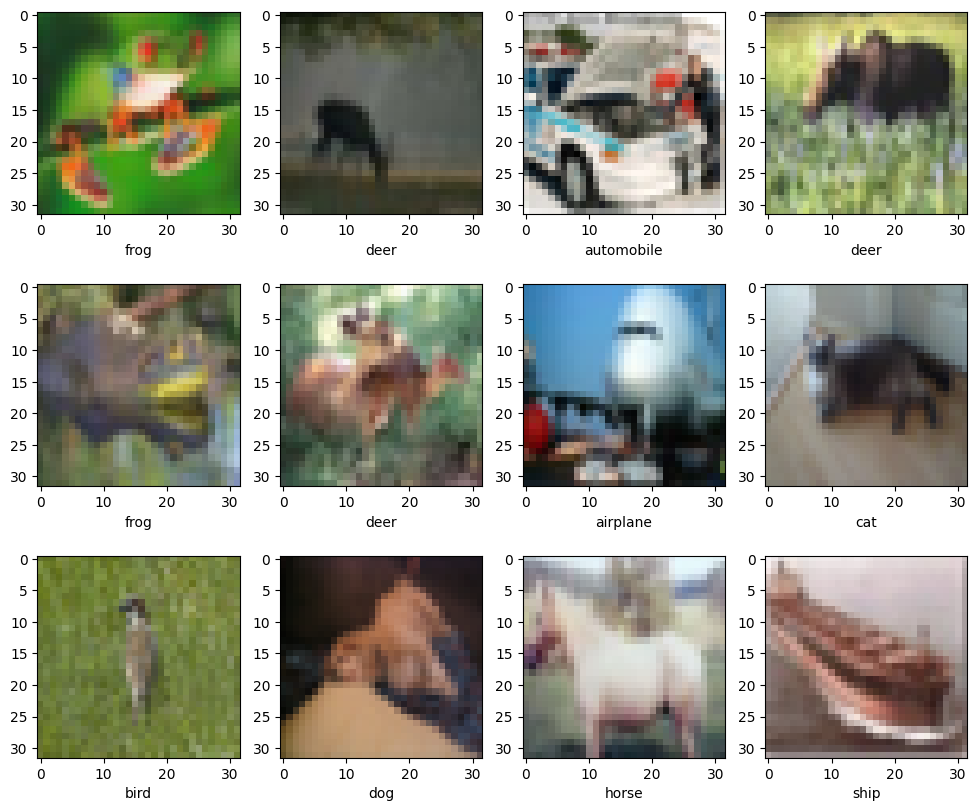

In [ ]:
%matplotlib inline

plt.figure(figsize=[12, 10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i], [1, 2, 0]))

In [ ]:
class CIFAR10(torch.utils.data.Dataset):
    def __init__(self, X, y, transform=None) -> None:
        super(CIFAR10, self).__init__()
        self.X = X
        self.y = y
        self.transform = transform

    def __getitem__(self, index) -> None:
        image = self.X[index] if not self.transform else self.transform(self.X[index])
        label = self.y[index]
        return image, label

    def __len__(self):
        return len(self.y)

data_train = CIFAR10(X_train, y_train)
data_val = CIFAR10(X_val, y_val)
data_test = CIFAR10(X_test, y_test)

loader_train = torch.utils.data.DataLoader(data_train, batch_size=512, shuffle=True)
loader_val = torch.utils.data.DataLoader(data_val, batch_size=512, shuffle=False)
loader_test = torch.utils.data.DataLoader(data_test, batch_size=512, shuffle=False)

In [ ]:
from collections import defaultdict
import lightning.pytorch as pl

class Wrapper(pl.LightningModule):
    def __init__(self, model):
        super(Wrapper, self).__init__()
        self.model = model
        self.train_step_outputs = defaultdict(list)
        self.validation_step_outputs = defaultdict(list)
        self.test_step_outputs = defaultdict(list)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x_batch, y_batch = batch
        logits = self(x_batch)
        loss = F.cross_entropy(logits, y_batch.to(dtype=torch.int64))
        accuracy = (logits.argmax(dim=1) == y_batch).to(dtype=torch.float32).mean()
        self.train_step_outputs['accuracy'].append(accuracy.item())
        self.train_step_outputs['loss'].append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        loss, accuracy = self._shared_eval_step(batch, batch_idx)
        self.validation_step_outputs['accuracy'].append(accuracy)
        self.validation_step_outputs['loss'].append(loss)
        self.log('val_accuracy', accuracy)
        return accuracy

    def test_step(self, batch, batch_idx):
        loss, accuracy = self._shared_eval_step(batch, batch_idx)
        self.test_step_outputs['accuracy'].append(accuracy)
        return accuracy

    def _shared_eval_step(self, batch, batch_idx):
        x_batch, y_batch = batch
        logits = self(x_batch)
        loss = F.cross_entropy(logits, y_batch.to(dtype=torch.int64))
        accuracy = (logits.argmax(dim=1) == y_batch).to(dtype=torch.float32).mean()
        return loss.item(), accuracy.item()

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x_batch, y_batch = batch
        logits = self(x_batch)
        return logits

    def on_train_epoch_end(self):
        self.train_step_outputs.clear()

    def on_validation_epoch_end(self):
        accuracy = np.mean(self.validation_step_outputs['accuracy'])
        loss = np.mean(self.validation_step_outputs['loss'])
        self.validation_step_outputs['accuracy'].clear()
        self.validation_step_outputs['loss'].clear()
        train_loss = np.mean(self.train_step_outputs['loss'])
        train_accuracy = np.mean(self.train_step_outputs['accuracy'])
        print(f'Validation: {accuracy=:.2%} {loss=:.5}. Train: {train_accuracy=:.2%} {train_loss=:.5}')

    def on_test_epoch_end(self):
        accuracy = np.mean(self.test_step_outputs['accuracy'])
        submission(accuracy)
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [ ]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

def get_trainer():
    trainer = pl.Trainer(
        accelerator='gpu', max_epochs=50, check_val_every_n_epoch=1,
        logger=False, enable_model_summary=False, enable_checkpointing=False,
        callbacks=[EarlyStopping(monitor='val_accuracy', mode='max')]
    )
    ipd.clear_output()
    return trainer


## Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

Let's start with a dense network for our baseline:

In [ ]:
model = nn.Sequential(
    nn.Flatten(start_dim=1),
    nn.Linear(in_features=3072, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=100),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=10),
)

dense_model = Wrapper(model).to(device)

In [ ]:
trainer = get_trainer()

trainer.fit(model=dense_model, train_dataloaders=loader_train, val_dataloaders=loader_val)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Validation: accuracy=8.89% loss=2.3051. Train: train_accuracy=nan% train_loss=nan


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: accuracy=33.79% loss=1.8424. Train: train_accuracy=27.43% train_loss=2.0099


Validation: 0it [00:00, ?it/s]

Validation: accuracy=34.10% loss=1.8075. Train: train_accuracy=35.91% train_loss=1.7979


Validation: 0it [00:00, ?it/s]

Validation: accuracy=39.52% loss=1.6874. Train: train_accuracy=38.65% train_loss=1.7163


Validation: 0it [00:00, ?it/s]

Validation: accuracy=40.15% loss=1.6871. Train: train_accuracy=41.16% train_loss=1.6554


Validation: 0it [00:00, ?it/s]

Validation: accuracy=40.09% loss=1.6658. Train: train_accuracy=42.79% train_loss=1.6108


Validation: 0it [00:00, ?it/s]

Validation: accuracy=41.84% loss=1.6252. Train: train_accuracy=43.69% train_loss=1.5869


Validation: 0it [00:00, ?it/s]

Validation: accuracy=44.93% loss=1.555. Train: train_accuracy=44.76% train_loss=1.5566


Validation: 0it [00:00, ?it/s]

Validation: accuracy=45.24% loss=1.5297. Train: train_accuracy=46.58% train_loss=1.5099


Validation: 0it [00:00, ?it/s]

Validation: accuracy=44.26% loss=1.5708. Train: train_accuracy=46.80% train_loss=1.4993


Validation: 0it [00:00, ?it/s]

Validation: accuracy=44.42% loss=1.5562. Train: train_accuracy=47.82% train_loss=1.4777


Validation: 0it [00:00, ?it/s]

Validation: accuracy=46.75% loss=1.5042. Train: train_accuracy=48.68% train_loss=1.4523


Validation: 0it [00:00, ?it/s]

Validation: accuracy=47.29% loss=1.4717. Train: train_accuracy=49.12% train_loss=1.4422


Validation: 0it [00:00, ?it/s]

Validation: accuracy=46.58% loss=1.48. Train: train_accuracy=49.91% train_loss=1.4173


Validation: 0it [00:00, ?it/s]

Validation: accuracy=45.89% loss=1.5354. Train: train_accuracy=50.37% train_loss=1.4046


Validation: 0it [00:00, ?it/s]

Validation: accuracy=48.31% loss=1.4459. Train: train_accuracy=50.75% train_loss=1.3909


Validation: 0it [00:00, ?it/s]

Validation: accuracy=47.08% loss=1.4901. Train: train_accuracy=51.36% train_loss=1.3785


Validation: 0it [00:00, ?it/s]

Validation: accuracy=48.81% loss=1.4528. Train: train_accuracy=52.21% train_loss=1.3555


Validation: 0it [00:00, ?it/s]

Validation: accuracy=44.96% loss=1.6228. Train: train_accuracy=52.45% train_loss=1.3497


Validation: 0it [00:00, ?it/s]

Validation: accuracy=48.72% loss=1.4516. Train: train_accuracy=51.58% train_loss=1.3674


Validation: 0it [00:00, ?it/s]

Validation: accuracy=47.84% loss=1.4594. Train: train_accuracy=53.38% train_loss=1.3214


Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.

Final test:


In [ ]:
accuracy = trainer.test(model=dense_model, dataloaders=loader_test)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Final results:
  test accuracy:		48.19 %
We need more magic! Follow instructons below


## Homework 1: small convolution net

### Task 1: First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(start_dim=1),
    nn.Linear(in_features=10*15*15, out_features=100),
    nn.ReLU(),
    nn.Dropout1d(p=0.1),
    nn.Linear(in_features=100, out_features=10),
)

conv_model_1 = Wrapper(model).to(device)

In [ ]:
trainer = get_trainer()

trainer.fit(model=conv_model_1, train_dataloaders=loader_train, val_dataloaders=loader_val)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Validation: accuracy=9.67% loss=2.3067. Train: train_accuracy=nan% train_loss=nan


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: accuracy=40.95% loss=1.7144. Train: train_accuracy=30.41% train_loss=1.9527


Validation: 0it [00:00, ?it/s]

Validation: accuracy=45.03% loss=1.5791. Train: train_accuracy=39.36% train_loss=1.706


Validation: 0it [00:00, ?it/s]

Validation: accuracy=46.61% loss=1.521. Train: train_accuracy=42.69% train_loss=1.608


Validation: 0it [00:00, ?it/s]

Validation: accuracy=48.86% loss=1.4603. Train: train_accuracy=44.59% train_loss=1.5493


Validation: 0it [00:00, ?it/s]

Validation: accuracy=49.53% loss=1.4418. Train: train_accuracy=46.16% train_loss=1.5057


Validation: 0it [00:00, ?it/s]

Validation: accuracy=50.75% loss=1.3967. Train: train_accuracy=46.95% train_loss=1.4775


Validation: 0it [00:00, ?it/s]

Validation: accuracy=51.08% loss=1.3822. Train: train_accuracy=48.69% train_loss=1.4359


Validation: 0it [00:00, ?it/s]

Validation: accuracy=52.79% loss=1.3313. Train: train_accuracy=49.87% train_loss=1.4047


Validation: 0it [00:00, ?it/s]

Validation: accuracy=53.10% loss=1.3261. Train: train_accuracy=50.58% train_loss=1.3811


Validation: 0it [00:00, ?it/s]

Validation: accuracy=54.54% loss=1.2883. Train: train_accuracy=51.79% train_loss=1.3508


Validation: 0it [00:00, ?it/s]

Validation: accuracy=55.25% loss=1.2667. Train: train_accuracy=52.68% train_loss=1.3202


Validation: 0it [00:00, ?it/s]

Validation: accuracy=54.41% loss=1.2903. Train: train_accuracy=53.36% train_loss=1.3027


Validation: 0it [00:00, ?it/s]

Validation: accuracy=56.94% loss=1.2241. Train: train_accuracy=54.30% train_loss=1.2777


Validation: 0it [00:00, ?it/s]

Validation: accuracy=57.76% loss=1.2124. Train: train_accuracy=55.17% train_loss=1.2546


Validation: 0it [00:00, ?it/s]

Validation: accuracy=57.97% loss=1.1947. Train: train_accuracy=55.61% train_loss=1.2431


Validation: 0it [00:00, ?it/s]

Validation: accuracy=58.74% loss=1.1796. Train: train_accuracy=56.44% train_loss=1.2196


Validation: 0it [00:00, ?it/s]

Validation: accuracy=58.26% loss=1.1816. Train: train_accuracy=56.97% train_loss=1.2047


Validation: 0it [00:00, ?it/s]

Validation: accuracy=58.45% loss=1.1659. Train: train_accuracy=57.75% train_loss=1.1865


Validation: 0it [00:00, ?it/s]

Validation: accuracy=58.51% loss=1.1714. Train: train_accuracy=58.24% train_loss=1.1738


In [ ]:
accuracy = trainer.test(model=conv_model_1, dataloaders=loader_test)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Final results:
  test accuracy:		58.15 %
Achievement unlocked: 60lvl Warlock!


__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.


### Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
    nn.BatchNorm2d(num_features=10),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(start_dim=1),
    nn.Linear(in_features=10*15*15, out_features=100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout1d(),
    nn.Linear(in_features=100, out_features=10),
)

conv_model_2 = Wrapper(model).to(device)

In [ ]:
trainer = get_trainer()

trainer.fit(model=conv_model_2, train_dataloaders=loader_train, val_dataloaders=loader_val)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Validation: accuracy=9.47% loss=2.3035. Train: train_accuracy=nan% train_loss=nan


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: accuracy=51.34% loss=1.5562. Train: train_accuracy=28.13% train_loss=1.9214


Validation: 0it [00:00, ?it/s]

Validation: accuracy=56.24% loss=1.4107. Train: train_accuracy=33.51% train_loss=1.7595


Validation: 0it [00:00, ?it/s]

Validation: accuracy=56.24% loss=1.3712. Train: train_accuracy=36.07% train_loss=1.6903


Validation: 0it [00:00, ?it/s]

Validation: accuracy=55.79% loss=1.367. Train: train_accuracy=38.23% train_loss=1.6435


Validation: 0it [00:00, ?it/s]

Validation: accuracy=61.08% loss=1.2303. Train: train_accuracy=39.30% train_loss=1.6057


Validation: 0it [00:00, ?it/s]

Validation: accuracy=60.06% loss=1.2323. Train: train_accuracy=39.81% train_loss=1.5849


Validation: 0it [00:00, ?it/s]

Validation: accuracy=59.12% loss=1.2469. Train: train_accuracy=41.48% train_loss=1.5508


Validation: 0it [00:00, ?it/s]

Validation: accuracy=58.50% loss=1.2408. Train: train_accuracy=42.36% train_loss=1.5281


In [ ]:
accuracy = trainer.test(model=conv_model_2, dataloaders=loader_test)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Final results:
  test accuracy:		57.56 %
Achievement unlocked: 60lvl Warlock!


### Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [ ]:
from torchvision import transforms

transforms_pipeline_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

transforms_pipeline_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])


In [ ]:
data_train = torchvision.datasets.CIFAR10(root='./cifar_data/', train=True, transform=transforms_pipeline_train)
data_test = torchvision.datasets.CIFAR10(root='./cifar_data/', train=False, transform=transforms_pipeline_test)

loader_train = torch.utils.data.DataLoader(dataset=data_train, batch_size=32, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset=data_test, batch_size=32, shuffle=False)


In [ ]:
conv_model_3 = Wrapper(model).to(device)

In [ ]:
trainer = get_trainer()

trainer.fit(model=conv_model_3, train_dataloaders=loader_train, val_dataloaders=loader_test)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Validation: accuracy=54.69% loss=1.9981. Train: train_accuracy=nan% train_loss=nan


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: accuracy=56.23% loss=1.3333. Train: train_accuracy=28.91% train_loss=1.8843


Validation: 0it [00:00, ?it/s]

Validation: accuracy=58.77% loss=1.3321. Train: train_accuracy=30.71% train_loss=1.8276


Validation: 0it [00:00, ?it/s]

Validation: accuracy=59.65% loss=1.2937. Train: train_accuracy=31.66% train_loss=1.8023


Validation: 0it [00:00, ?it/s]

Validation: accuracy=59.61% loss=1.2917. Train: train_accuracy=32.27% train_loss=1.7872


Validation: 0it [00:00, ?it/s]

Validation: accuracy=61.15% loss=1.252. Train: train_accuracy=32.53% train_loss=1.7789


Validation: 0it [00:00, ?it/s]

Validation: accuracy=62.27% loss=1.2436. Train: train_accuracy=33.04% train_loss=1.7658


Validation: 0it [00:00, ?it/s]

Validation: accuracy=62.60% loss=1.2409. Train: train_accuracy=33.56% train_loss=1.7535


Validation: 0it [00:00, ?it/s]

Validation: accuracy=62.94% loss=1.2342. Train: train_accuracy=33.75% train_loss=1.7509


Validation: 0it [00:00, ?it/s]

Validation: accuracy=64.47% loss=1.2009. Train: train_accuracy=33.93% train_loss=1.7438


Validation: 0it [00:00, ?it/s]

Validation: accuracy=63.99% loss=1.197. Train: train_accuracy=34.03% train_loss=1.7385


Validation: 0it [00:00, ?it/s]

Validation: accuracy=64.04% loss=1.1986. Train: train_accuracy=34.24% train_loss=1.7336


Validation: 0it [00:00, ?it/s]

Validation: accuracy=64.41% loss=1.189. Train: train_accuracy=34.62% train_loss=1.7255


In [ ]:
accuracy = trainer.test(model=conv_model_2, dataloaders=loader_test)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Final results:
  test accuracy:		64.41 %
Achievement unlocked: 70lvl Warlock!


## Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.

### Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons,
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or with weight_decay parameter of a optimizer ([for example SGD's doc](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   
### Data augmemntation
   * getting 5x as large dataset for free is a great
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
```

```

```

```

```

```

```

```


### Submission

In [ ]:
transforms_pipeline_train = transforms.Compose([
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

transforms_pipeline_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])


In [ ]:
data_train = torchvision.datasets.CIFAR10(root='./cifar_data/', train=True, transform=transforms_pipeline_train)
data_test = torchvision.datasets.CIFAR10(root='./cifar_data/', train=False, transform=transforms_pipeline_test)

loader_train = torch.utils.data.DataLoader(dataset=data_train, batch_size=32, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset=data_test, batch_size=32, shuffle=False)


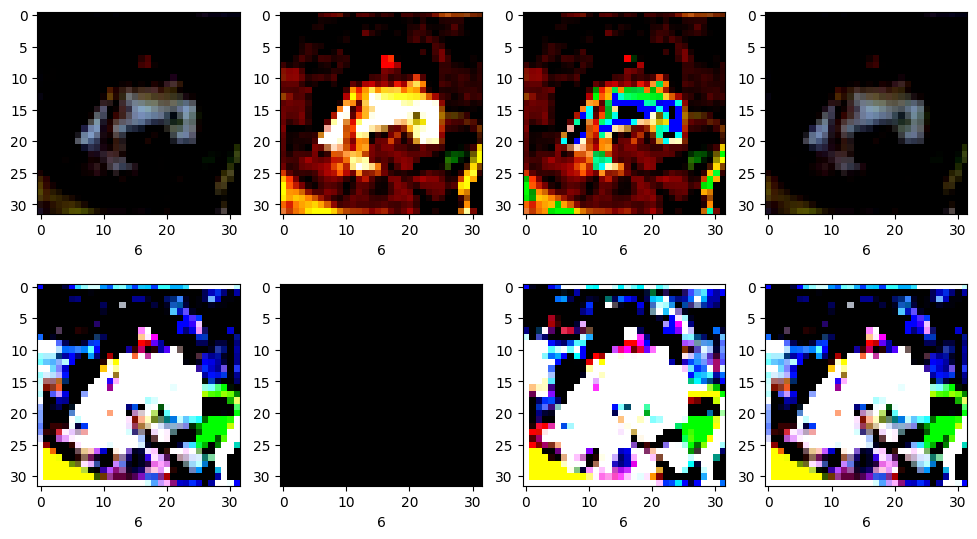

In [ ]:
%matplotlib inline

plt.figure(figsize=[12, 10])
for i in range(8):
    image, label = data_train[0]
    plt.subplot(3, 4, i + 1)
    plt.xlabel(label)
    plt.imshow(image.permute(1, 2, 0).numpy())


In [ ]:
def convolution_block(in_channels, out_channels, kernel_size, padding, max_pooling=2):
    block = nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding
            ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=max_pooling),
    )

    return block

In [ ]:
def dense_block(in_features, out_features):
    block = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=out_features),
        nn.BatchNorm1d(num_features=out_features),
        nn.Dropout1d(p=0.2),
        nn.ReLU(),
    )

    return block

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.enc1_block = convolution_block(  3, 128, 3, 1, 2) # 16x16
        self.enc2_block = convolution_block(128, 256, 3, 1, 2) #  8x8
        self.enc3_block = convolution_block(256, 512, 3, 1, 2) #  4x4
        self.enc4_block = convolution_block(512,1024, 3, 1, 2) #  2x2

        inputs = 1024 * 2 * 2

        self.den1_block = dense_block(inputs, 100)
        self.den2_block = dense_block(   100,  50)
        self.output = nn.Linear(50, 10)

    def forward(self, x):

        # downsampling part
        x = self.enc1_block(x)
        x = self.enc2_block(x)
        x = self.enc3_block(x)
        x = self.enc4_block(x)

        x = x.flatten(start_dim=1)

        # fully-connected part
        x = self.den1_block(x)
        x = self.den2_block(x)
        return self.output(x)

model = ConvNet().to(device)

conv_model_4 = Wrapper(model).to(device)

In [ ]:
trainer = get_trainer()

trainer.fit(model=conv_model_4, train_dataloaders=loader_train, val_dataloaders=loader_test)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Validation: accuracy=14.06% loss=2.2933. Train: train_accuracy=nan% train_loss=nan


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: accuracy=58.89% loss=1.258. Train: train_accuracy=30.91% train_loss=1.8587


Validation: 0it [00:00, ?it/s]

Validation: accuracy=69.22% loss=0.97729. Train: train_accuracy=40.82% train_loss=1.6108


Validation: 0it [00:00, ?it/s]

Validation: accuracy=72.87% loss=0.85496. Train: train_accuracy=44.87% train_loss=1.4997


Validation: 0it [00:00, ?it/s]

Validation: accuracy=74.45% loss=0.80147. Train: train_accuracy=47.73% train_loss=1.4254


Validation: 0it [00:00, ?it/s]

Validation: accuracy=76.70% loss=0.71997. Train: train_accuracy=49.90% train_loss=1.3696


Validation: 0it [00:00, ?it/s]

Validation: accuracy=78.12% loss=0.66554. Train: train_accuracy=51.13% train_loss=1.3317


Validation: 0it [00:00, ?it/s]

Validation: accuracy=81.02% loss=0.59906. Train: train_accuracy=52.61% train_loss=1.2908


Validation: 0it [00:00, ?it/s]

Validation: accuracy=80.91% loss=0.58682. Train: train_accuracy=54.21% train_loss=1.2526


Validation: 0it [00:00, ?it/s]

Validation: accuracy=82.35% loss=0.54462. Train: train_accuracy=54.92% train_loss=1.2255


Validation: 0it [00:00, ?it/s]

Validation: accuracy=82.07% loss=0.541. Train: train_accuracy=56.51% train_loss=1.1872


Validation: 0it [00:00, ?it/s]

Validation: accuracy=82.73% loss=0.52102. Train: train_accuracy=57.20% train_loss=1.1652


Validation: 0it [00:00, ?it/s]

Validation: accuracy=82.52% loss=0.5373. Train: train_accuracy=58.22% train_loss=1.1423


Validation: 0it [00:00, ?it/s]

Validation: accuracy=82.90% loss=0.50909. Train: train_accuracy=58.61% train_loss=1.1227


Validation: 0it [00:00, ?it/s]

Validation: accuracy=82.78% loss=0.51258. Train: train_accuracy=59.72% train_loss=1.0972


Validation: 0it [00:00, ?it/s]

Validation: accuracy=84.38% loss=0.47025. Train: train_accuracy=60.09% train_loss=1.0818


Validation: 0it [00:00, ?it/s]

Validation: accuracy=82.97% loss=0.50727. Train: train_accuracy=60.86% train_loss=1.0677


Validation: 0it [00:00, ?it/s]

Validation: accuracy=83.55% loss=0.48527. Train: train_accuracy=60.77% train_loss=1.0671


Validation: 0it [00:00, ?it/s]

Validation: accuracy=83.75% loss=0.47517. Train: train_accuracy=61.24% train_loss=1.0518


In [ ]:
_ = trainer.test(model=conv_model_4, dataloaders=loader_test)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Final results:
  test accuracy:		83.75 %
Achievement unlocked: 110lvl Warlock!


### Pre-trained benchmark

In [ ]:
!wget https://raw.githubusercontent.com/akamaster/pytorch_resnet_cifar10/master/resnet.py
!wget https://github.com/akamaster/pytorch_resnet_cifar10/raw/master/pretrained_models/resnet1202-f3b1deed.th

ipd.clear_output()

In [ ]:
from resnet import ResNet, BasicBlock

resnet1202 = nn.DataParallel(ResNet(BasicBlock, [200, 200, 200]))

state_dict = torch.load('/content/resnet1202-f3b1deed.th')
state_dict = state_dict['state_dict']

resnet1202.load_state_dict(state_dict)


<All keys matched successfully>

In [ ]:
_ = get_trainer().test(model=Wrapper(resnet1202).to(device), dataloaders=loader_test)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Final results:
  test accuracy:		93.82 %
U'r freakin' amazin'!
